# Part 4. Generative Adversarial Networks (GANs) — 15 points

## Links

- https://en.wikipedia.org/wiki/Generative_adversarial_network
- https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29

## Theory

### Intro

Now we will consider another implicit generative model.

Implicit models (in contrary to explicit VAE), do not provide a direct access to the modeled data distribution $p(x)$, but only allow to sample from it.

Though this may be an advantage rather than a disadvantage. Most of the explicit models have to make assumptions about the shape of the data distribution. For example, in VAEs the assumption is that each image comes from a normal distribution, with each pixel being _independent_ of each other. Needless to say, this model is far from being ideal for modelling the natural images, because we all know that pixels in the image strongly depend not only on their neighbours, but sometimes on the global context as well.

<img src="https://bit.ly/3567LM6" width=320px>

This is why it is hard for us to believe that the image above is real, even though all local patches are perfectly real :)

### Method description

In order to overcome limitations of tracktable families of probabilistic models, we have to go intractable. Currently, Generative Adversarial Networks is the most successful example of such models.

__Key idea__ of GANs is the use of a loss function that is trained from the data.

A good analogy is a counterfeiter vs a cop example:

<img src="https://www.cfml.se/img/blog/generative_adversarial_networks/counterfeiter_vs_cop.jpg" width=640px>

A counterfeiter is a "generator" neural network that is being trained to produce realistic data points (not neccessarily images). A cop is a "discriminator" neural network trained to recognize fake data points. The counterfeiter gets constant updates from the cop via a gradient flow (backpropagation) and tries to maximize the realism score a cop is assigning to fake data points. The cop receives the feedback via the update of the available dataset, and tries to maximize the recognition accuracy.

If we denote $G$ as a generator, with $\hat{x}$ being its output, $D$ as a discriminator and $\mathcal{L}(s, \hat{s})$ as a classification function (with $s$ denoting class scores) the cop would want to minimize (say, binary cross entropy), then the objective can be written as a zero-sum game (since a classification function is typically symmetric w.r.t. classes): 

$$
    \max_G \min_D \mathcal{L} \big( D(x), D(\hat{x}) \big).
$$

In practice, however, for numerous reasons it is useful to separate this single objective into two, leading to a potentially non-zero sum game:

$$
    \max_G \min_D \mathcal{L}_G \big( D(x), D(\hat{x}) \big) + \mathcal{L}_D ( D(x), D(\hat{x}) \big),
$$

with gradients from the objective $\mathcal{L}_G$ being back-propagated only into the generator, and $\mathcal{L}_D$ — only into the discriminator.

### Training stability

The objective above is typically optimized via an alternating stochastic gradient descend technique: i.e., we first do an optimization step w.r.t. one network, and then use updated weights to perform a step w.r.t. another network. Although this technique has convergence issues [1], it is still widely used for its simplicity and memory efficiency.

Also, although GANs used to be notoriously hard to train, a number of techniques [2, 3] have been developed to overcome the difficulties.

Still, when we are talking about GANs, it is incorrect to use a term "convergence", because even with the aforementioned techniques, the optimization process does not converge to a state when the loss of the generator converges to zero. On contrary, it is a __red flag__ indicating a __training instability__ if this loss converges to zero. In practice, this means that the generator is fooling the discriminator with garbage.

Ideal training curves look like that:

<img src="https://i.ibb.co/0csVDhH/gans-training-curves.png" alt="source: https://deepai.org/publication/geogan-a-conditional-gan-with-reconstruction-and-style-loss-to-generate-standard-layer-of-maps-from-satellite-images" width=640px>

Bad training curves look like that:

<img src="https://miro.medium.com/max/2732/1*4A5bo8gVG9wmg-5wtqavOg.png" width=640px>

The weights of both the generator and discriminator keep constantly updating during training, resulting in a typical oscilation behavior [1].

Usually ideal training curves end up like the bad ones if you train long enough — all you can do is taking a checkpoint right before the training collapses (you can see this point clearly on the second plot). If the training process was stable, this collapse happends long after the results have stopped improving, though some models still struggle to obtain stable enough behavior for data with high dimensionality [4].

## Task

Implement and train a generative adversarial network using the provided dataset in 3 variants:

1. with a spectral normalization,
2. with a gradient penalty,
3. without any regularization.

Also try turning on and off batch normalization in the generator network for all approaches. Note that spectral normalization and batch normalization can be used simultaneously, since SN is only applied to linear and convolutional layers.

Visualize the resulting learning curves for all approaches and provide a side-by-side comparison for a small (~10 items) subset of samples for each method. Your learning curves should look similar to the "ideal" curves above.

## Notes

- Use Adam optimizer with $\beta_1 = 0$ for both the generator and the discriminator.
- Start with the learning rate equal to $1 \cdot 10^{-4}$ for both networks. Increase the learning rate by a factor of 4 for the discriminator, when using spectral normalization.
- Use PyTorch implementation of spectral normalization (__torch.nn.utils.SpectralNorm__). Implement a gradient penalty by hand using the following equations and __torch.autograd.grad__ (pass discriminator outputs to _outputs_, inputs to _inputs_, and ones to grad_outputs, set _retain_graph_ to True):


$$
    \mathcal{L}_\text{GP} = 10 \cdot \mathbb{E}_{x \sim p(x)} (||\nabla_x D(x)||_2 - 1)^2
$$

- Use hinge loss for training, but feel free to experiment with other losses as well for bonus points.

\begin{aligned}
    & \mathcal{L}_D = \mathbb{E}_{x \sim p(x)}\, \text{max}\big( 0, 1 - D(x) \big) + \mathbb{E}_{z \sim p(z)}\, \text{max}\big( 0, 1 + D(G(z)) \big) \\
    & \mathcal{L}_G = - \mathbb{E}_{z \sim p(z)}\, D(G(z))
\end{aligned}

## References

[1] Mescheder et. al., "Which Training Methods for GANs do actually Converge?", ICML 2018, https://arxiv.org/abs/1801.04406

[2] Miyato et. al., "Spectral Normalization for Generative Adversarial Networks", ICLR 2018, https://arxiv.org/abs/1802.05957

[3] Gulrajani et. al., "Improved Training of Wasserstein GANs", NeurIPS 2017, https://arxiv.org/abs/1704.00028

[4] Brock et. al., "Large Scale GAN Training for High Fidelity Natural Image Synthesis", ICLR 2018, https://arxiv.org/abs/1809.11096

In [1]:
#@title Utility functions
import numpy as np
import os
import skimage.io
import skimage
import skimage.transform
import pandas as pd

def fetch_lfw_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      raw_images_name = "lfw",
                      use_raw=False,
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ): # sad smile

    #download if not exists
    if (not use_raw) and not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)
    
    if use_raw and not os.path.exists(raw_images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(raw_images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    dirname = raw_images_name if use_raw else images_name
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(dirname):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    #mass-merge
    #(photos now have same order as attributes)
    df_attrs['imagenum'] = df_attrs['imagenum'].astype(np.int64)
    df = pd.merge(df_attrs, photo_ids, on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos = df['photo_path'].apply(lambda img: skimage.io.imread(img))\
                                 .apply(lambda img:img[dy:-dy,dx:-dx])\
                                 .apply(lambda img: skimage.img_as_ubyte(skimage.transform.resize(img,[dimx,dimy])))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

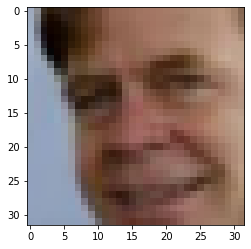

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
data,attrs = fetch_lfw_dataset(dimx=32, dimy=32)

# Preprocess faces
data = np.float32(data).transpose([0, 3, 1, 2]) / 127.5 - 1.0

IMG_SHAPE = data.shape[1:]

# Print random image
plt.imshow(((data[np.random.randint(data.shape[0])] + 1) / 2.0).transpose([1, 2, 0]),
           cmap="gray", interpolation="none")

In [3]:
import torch, torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

Torch version: 1.7.0+cu101
Using GPU


In [4]:
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.cuda() if use_cuda else noise.cpu()
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape=shape
    def forward(self,input):
        return input.view(self.shape)

### Generator

Example generator architecture is provided below: use it as a reference for you architectures, but feel free to experiment. If your experiments are shown to improve over baseline performance, you will be rewarded with bonus points.

In our realization, please insert batch normalization before nonlinearities.

In [5]:
CODE_SIZE = 256

from itertools import count
# automatic layer name maker. Don't do this in production :)
ix = ('layer_%i'%i for i in count())

generator = nn.Sequential(
    nn.Linear(CODE_SIZE, 256 * 4 * 4),
    Reshape([-1, 256, 4, 4]),
    nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.LeakyReLU(0.2),
    nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.LeakyReLU(0.2),
    nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.LeakyReLU(0.2),
    nn.Conv2d(32, 3, kernel_size=3, padding=1),
    nn.Tanh()
)

if use_cuda: generator.cuda()

In [6]:
generated_data = generator(sample_noise_batch(5)) #5 is the batch size here
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s" % (IMG_SHAPE,generated_data.shape)

In [7]:
generated_data.shape

torch.Size([5, 3, 32, 32])

### Discriminator
Discriminator is your usual convolutional network with interlooping convolution and pooling layers

The network does not include dropout/batchnorm to avoid learning complications.

The convolutional part of the discriminator should mirror the generator (with the exception of the first and the last layers).

In [8]:
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(data.shape[0]), size=batch_size)
    batch = torch.tensor(data[idxs], dtype=torch.float32)
    return batch.cuda() if use_cuda else batch.cpu()

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

## Models

In [9]:
### YOUR CODE - create convolutional architecture for discriminator
### Note: please start simple. A few convolutions & poolings would do, inception/resnet is an overkill

from torch.nn.utils import spectral_norm
batchSize = 50

def baseline():

    generator = nn.Sequential(
        nn.Linear(CODE_SIZE, 256 * 4 * 4),
        Reshape([-1, 256, 4, 4]),
        nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 3, kernel_size=3, padding=1),
        nn.Tanh()
    )

    discriminator = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.MaxPool2d(2),
        nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.MaxPool2d(2),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.MaxPool2d(2),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(128, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.MaxPool2d(2),
        nn.LeakyReLU(0.2),
        Reshape([batchSize, 256*16*16]),
        nn.Linear(256*16*16, 1), 
        #nn.Sigmoid(),
    )

    if use_cuda: discriminator.cuda()
    if use_cuda: generator.cuda()

    return generator, discriminator

def spectralNorm():

    generator = nn.Sequential(
        spectral_norm(nn.Linear(CODE_SIZE, 256 * 4 * 4)),
        Reshape([-1, 256, 4, 4]),
        spectral_norm(nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)),
        nn.LeakyReLU(0.2),
        spectral_norm(nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)),
        nn.LeakyReLU(0.2),
        spectral_norm(nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)),
        nn.LeakyReLU(0.2),
        spectral_norm(nn.Conv2d(32, 3, kernel_size=3, padding=1)),
        nn.Tanh(),
    )

    discriminator = nn.Sequential(
        spectral_norm(nn.Conv2d(3, 32, kernel_size=3, padding=1)),
        nn.MaxPool2d(2),
        spectral_norm(nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1)),
        nn.MaxPool2d(2),
        nn.LeakyReLU(0.2),
        spectral_norm(nn.ConvTranspose2d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1)),
        nn.MaxPool2d(2),
        nn.LeakyReLU(0.2),
        spectral_norm(nn.ConvTranspose2d(128, 256, kernel_size=3, stride=2, padding=1, output_padding=1)),
        nn.MaxPool2d(2),
        nn.LeakyReLU(0.2),
        Reshape([batchSize, 256*16*16]),
        spectral_norm(nn.Linear(256*16*16, 1)), 
        #nn.Sigmoid(),
    )

    if use_cuda: discriminator.cuda()
    if use_cuda: generator.cuda()

    return generator, discriminator

def baseline_batchnorm():

    generator = nn.Sequential(
        nn.Linear(CODE_SIZE, 256 * 4 * 4),
        Reshape([-1, 256, 4, 4]),
        nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 3, kernel_size=3, padding=1),
        nn.BatchNorm2d(3),
        nn.Tanh()
    )

    discriminator = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2),
        nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(128, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(2),
        nn.LeakyReLU(0.2),
        Reshape([batchSize, 256*16*16]),
        nn.Linear(256*16*16, 1), 
        #nn.Sigmoid(),
    )

    if use_cuda: discriminator.cuda()
    if use_cuda: generator.cuda()

    return generator, discriminator

def spectralNorm_batchnorm():

    generator = nn.Sequential(
        spectral_norm(nn.Linear(CODE_SIZE, 256 * 4 * 4)),
        Reshape([-1, 256, 4, 4]),
        spectral_norm(nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        spectral_norm(nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        spectral_norm(nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        spectral_norm(nn.Conv2d(32, 3, kernel_size=3, padding=1)),
        nn.BatchNorm2d(3),
        nn.Tanh(),
    )

    discriminator = nn.Sequential(
        spectral_norm(nn.Conv2d(3, 32, kernel_size=3, padding=1)),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2),
        spectral_norm(nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1)),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
        nn.LeakyReLU(0.2),
        spectral_norm(nn.ConvTranspose2d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1)),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
        nn.LeakyReLU(0.2),
        spectral_norm(nn.ConvTranspose2d(128, 256, kernel_size=3, stride=2, padding=1, output_padding=1)),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(2),
        nn.LeakyReLU(0.2),
        Reshape([batchSize, 256*16*16]),
        spectral_norm(nn.Linear(256*16*16, 1)), 
        #nn.Sigmoid(),
    )

    if use_cuda: discriminator.cuda()
    if use_cuda: generator.cuda()

    return generator, discriminator

In [10]:
# YOUR TRAINING CODE HERE

## Losses; gradient penalty

In [11]:
# This loss did not work out for me (used with a sigmoid on the output of the discriminator)
# def generatorLoss (z):
#     return -discriminator(generator(z)).sum()

# def discriminatorLoss (realX, z):
#     return ((1 - discriminator(realX)) + discriminator(generator(z))).sum()

def generatorLoss (z):
    return -discriminator(generator(z)).mean()

def discriminatorLoss (realX, z):
    realPart = (torch.clamp(1 - discriminator(realX), min=0)).mean()
    fakePart = (torch.clamp (1 + discriminator(generator(z)), min=0)).mean()
    return realPart + fakePart

In [12]:
#gradient penalty 
from torch.autograd import Variable

def gradPenalty (realX, z):

    realX = Variable(realX, requires_grad=True)
    z = Variable(z, requires_grad=True)

    fakeInput = generator(z)

    outTrue = discriminator(realX)
    outFake = discriminator(fakeInput)

    gradientsTrue = torch.autograd.grad(outputs=outTrue, inputs=realX, grad_outputs=torch.ones(outTrue.size()).cuda(), retain_graph=True)[0]
    gradientsTrue = gradientsTrue.reshape(50, -1) #flattening every sample in the batch
    gradientsFake = torch.autograd.grad(outputs=outFake, inputs=fakeInput, grad_outputs=torch.ones(outFake.size()).cuda(), retain_graph=True)[0]
    gradientsFake = gradientsFake.reshape(50, -1) #flattening every sample in the batch

    gradientsTrue_norm = torch.sqrt(torch.sum(gradientsTrue**2, dim=1))
    gradientsFake_norm = torch.sqrt(torch.sum(gradientsFake**2, dim=1))

    norm = 10* (((gradientsTrue_norm -1 )**2).mean() + ((gradientsFake_norm -1 )**2).mean())
    return norm

## Training

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


baseline; iteration: 200


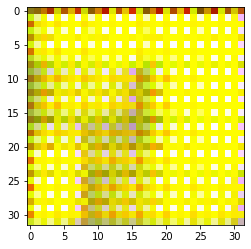

KeyboardInterrupt: ignored

In [ ]:
import os
from torch import optim
# batchSize was set to 50 in the cell with discriminator

# for j in range(6):
# collab interrupted on j=2
for j in range(6):

    if (j==0):
        expName = 'baseline'
        FLAG_gradPenalty=0
        FLAG_specnorm=0
        FLAG_baseline=1 #just to check (no use)
        generator, discriminator = baseline()
        N = 8000
    elif (j==1):
        expName = 'spectralNorm'
        FLAG_gradPenalty=0
        FLAG_specnorm=1
        FLAG_baseline=0 #just to check (no use)
        generator, discriminator = spectralNorm()
        N = 8000
    elif (j==2):
        expName = 'GP'
        FLAG_gradPenalty=1
        FLAG_specnorm=0
        FLAG_baseline=0 #just to check (no use)
        generator, discriminator = baseline()
        N = 8000
        #collab interrupted here
    elif (j==3):
        expName = 'baseline_BN'
        FLAG_gradPenalty=0
        FLAG_specnorm=0
        FLAG_baseline=1 #just to check (no use)
        generator, discriminator = baseline_batchnorm()
        N = 4000
    elif (j==4):
        expName = 'spectralNorm_BN'
        FLAG_gradPenalty=0
        FLAG_specnorm=1
        FLAG_baseline=0 #just to check (no use)
        generator, discriminator = spectralNorm_batchnorm()
        N = 4000
    elif (j==5):
        expName = 'GP_BN'
        FLAG_gradPenalty=1
        FLAG_specnorm=0
        FLAG_baseline=0 #just to check (no use)
        generator, discriminator = baseline_batchnorm()
        N = 4000

    directory = '/content/drive/My Drive/DL20_HW3/' + expName
    if not os.path.exists(directory):
        os.mkdir(directory)

    count = 0
    lr = 1e-4
    if FLAG_specnorm: lr = 4e-4
    optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(0,0.999)) #beta2 set to default 
    optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(0,0.999)) #beta2 set to default 

    GLosses = []
    DLOsses = []
    while count < N:
        count += 1
        realX = sample_data_batch(50)
        z = sample_noise_batch(50)

        optimizerG.zero_grad()
        GLoss = generatorLoss (z)
        GLoss.backward()
        optimizerG.step()
        GLosses.append(GLoss.detach().cpu().item())

        for i in range (5):
            optimizerD.zero_grad()
            if FLAG_gradPenalty:
                DLoss = discriminatorLoss (realX, z) + gradPenalty (realX, z)
            else:
                DLoss = discriminatorLoss (realX, z)
            DLoss.backward()
            optimizerD.step()
            if i==4:
                DLOsses.append(DLoss.detach().cpu().item())

        if count%200==0:
            out = expName + '; iteration: ' + str(count) 
            print(out)
            z = sample_noise_batch(2)
            val_gen = generator(z).data.cpu().numpy()
            plt.imshow(((val_gen[0] + 1) / 2.0).transpose([1, 2, 0]),
              cmap="gray", interpolation="none")
            plt.show()

            model_save_name = expName + '/' + str(count)
            path = F"/content/drive/My Drive/DL20_HW3/{model_save_name}" 
            torch.save(generator, path)

            model_save_name = expName + '_D'
            path = F"/content/drive/My Drive/DL20_HW3/{model_save_name}" 
            np.save(path, DLOsses)

            model_save_name = expName + '_G'
            path = F"/content/drive/My Drive/DL20_HW3/{model_save_name}" 
            np.save(path, GLosses)

## Comparison of different approches 

In [187]:
def plot_gallery(images, h, w, n_row=6, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(((images[i] + 1) / 2.0).transpose([1, 2, 0]),
    cmap="gray", interpolation="none")
        plt.xticks(())
        plt.yticks(())
    plt.show()

baseline/8000 itearations


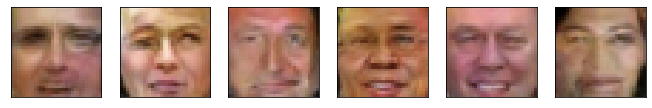

spectralNorm/8000 itearations


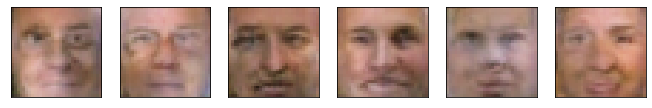

GP/8000 itearations


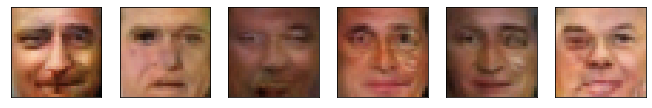

baseline_BN/4000 itearations


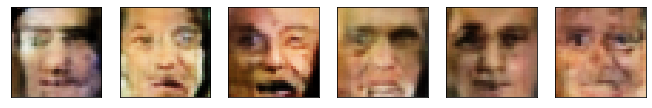

spectralNorm_BN/4000 itearations


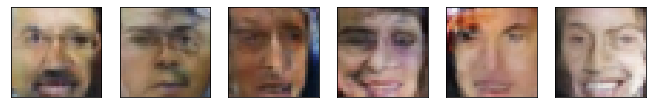

GP_BN/4000 itearations


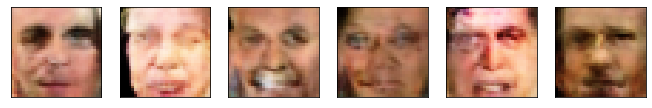

In [188]:
models = ['baseline', 'spectralNorm', 'GP', 'baseline_BN', 'spectralNorm_BN', 'GP_BN']

for i, model in enumerate(models):

    # print(i)
    # print(model)

    if (i<3): N=8000
    else: N=4000

    model_save_name = model + '/' + str(N)
    path = F"/content/drive/My Drive/test_dir/{model_save_name}" 
    net = torch.load(path, map_location='cpu')
    net = net.cuda()
    if(i>2): net.eval()

    print(model_save_name + ' itearations')
    z = sample_noise_batch(6)
    val_gen = net(z).data.cpu().numpy()
    plot_gallery(val_gen, 32, 32, n_row=1, n_col=6)

## MMD experiments

In [170]:
from mmd import MMD_3_Sample_Test
from tqdm.notebook import tqdm

In [ ]:
models = ['baseline', 'spectralNorm', 'GP', 'baseline_BN', 'spectralNorm_BN', 'GP_BN']
N_samples = 1000

p_vals = []


for i in tqdm(range(100)):

    N_epoch = 8000
    model = models[0]
    model_save_name = model + '/' + str(N_epoch)
    path = F"/content/drive/My Drive/test_dir/{model_save_name}" 
    net = torch.load(path, map_location='cpu')
    net = net.cuda()
    net.eval();

    z = sample_noise_batch(N_samples)
    baseline_gen = net(z).data.cpu().numpy().mean(axis=1).reshape((N_samples, -1))
    #baseline_gen = np.tensordot(baseline_gen, [0.299, 0.587, 0.114],axes=([1],[0])).reshape((N_samples, -1))

    N_epoch = 4000
    model = models[3]
    model_save_name = model + '/' + str(N_epoch)
    path = F"/content/drive/My Drive/test_dir/{model_save_name}" 
    net = torch.load(path, map_location='cpu')
    net = net.cuda()
    net.eval();

    z = sample_noise_batch(N_samples)
    baseline_bn_gen = net(z).data.cpu().numpy().mean(axis=1).reshape((N_samples, -1))
    #baseline_bn_gen = np.tensordot(baseline_bn_gen, [0.299, 0.587, 0.114],axes=([1],[0])).reshape((N_samples, -1))

    samples_init = []
    for i in range(N_samples):
      samples_init.append (data[np.random.randint(data.shape[0])])
    samples_init = np.array(samples_init).mean(axis=1).reshape((N_samples, -1))
    #samples_init = np.tensordot(samples_init, [0.299, 0.587, 0.114],axes=([1],[0])).reshape((N_samples, -1))

    p_vals.append (MMD_3_Sample_Test (samples_init, baseline_bn_gen, baseline_gen)[0])

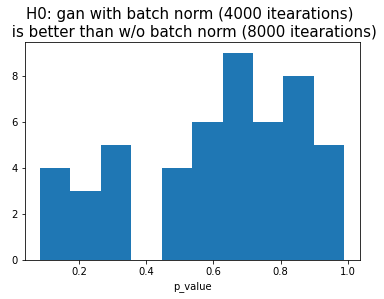

In [201]:
plt.hist(p_vals)
plt.xlabel('p_value')
plt.title('H0: gan with batch norm (4000 itearations) \n is better than w/o batch norm (8000 itearations)', size=15)
plt.show()

Normal guys


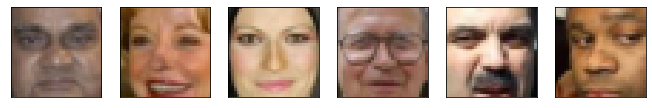

In [190]:
samples_init = []
for i in range(6):
  samples_init.append (data[np.random.randint(data.shape[0])])
samples_init = np.array(samples_init)
print('Normal guys')
plot_gallery(samples_init, 32, 32, n_row=1, n_col=6)

In [186]:
data.shape

(13143, 3, 32, 32)